# Multi-Taxi Environment Demonstration

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sarah-keren/multi_taxi/blob/main/MultiTaxiEnvDemo.ipynb)

## In the followin example we will demonstrate:
1. Setting up the environment, and general view of the map.
2. Doc the adjustable parameters.
3. The different formats of observations.
4. Show how to change the reward table.

In [1]:
# installing easily via pip
!pip install -q 'git+https://github.com/sarah-keren/multi-taxi'

### Environment's Parameters
1. <code>num_taxis</code> - the number of taxis operating in the envorinment. _default=1_.
2. <code>num_passengers</code> - the number of passengers to drive in the envorinment. _default=1_.
3. <code>max_fuel</code> - if <code>None</code> - each taxi has unlimited fuel to spent, else, this is the amount of fuel in a full-tank, and this amount decreases by 1 in each timestep unless taxis fill their tank at the station with a special action._default=<code>None</code>_.
4. <code>domain_map</code> - array of chars, representing the environment map with special characters for taxis initilized spots and fuel stations. _default=pre-defined map_.
5. <code>taxis_capacity</code> - a list of integers, where the i'th element represents the i'th taxi's passengers limit, where <code>None</code> represents unlimitted capacity. _default=None_.
6. <code>collision_sensitive_domain</code> - if <code>True</code> - taxis that move to the same grid point in the map - collide and stop their operation, otherwise, there can be multiple taxis at the same grid point. _default=False_.
7. <code>fuel_type_list</code> - a list of either 'F' or 'G', where each element represents the fuel type of each taxi (F for *F*uel and G for *G*as), if <code>None</code> - all are fuel. _default=None_.
8. <code>option_to_stand_by</code> - if <code>True</code> - taxis have the option to take *no_action*. _default=False_.
9. <code>view_len</code> - relevant for image observations, defines the size of the window of sight of the taxis' observations, _default=2_.
10. <code>rewards_table</code> - a dictionary that defines changes in the original reward table, see description below, _default=default_reward_table_.
11. <code>observation_type</code> - either 'symbolic' or 'image', indicating the type of observations to the taxis, _default='symbolic'.
12. <code>can_see_others</code> - If <code>True</code> and in symbolic observations mode, taxis will have other taxis' locations in their observations. _default=<code>False</code>,_. Note that in image oservations taxis can always see each other.
13. `stochastic_action_function` - A function that defines stochastic actions for all taxis. the inputis the desired action name and the output is any valid action name. see `actions_utils.StochasticActionFunction` for an example. Can be a dictionary of stochastic action functions in the format taxi_name --> stochastic_action_function_for_taxi. This will cause different taxis to have different action stochasticity. Taxis that do not appear in the dictionary will have deterministic actions. Invalid taxi names will be ignored. Default value is `None`, meaning all actions are deterministic for all taxis.
14. `pickup_only` - Simplifies the problem to only pick up all passengers, without needing dropping them off. _default=False_

In [2]:
from multi_taxi.taxi_environment import TaxiEnv

env_instance = TaxiEnv(num_taxis=3,                  # 3 taxi agents in the environment
                       num_passengers=2,             # 2 passengers in the environment
                       max_fuel = [30, 50, 25],      # taxi1 has a capacity of 30 fuel units, tax2 has 50, and taxi3 has 25
                       taxis_capacity=None,          # unlimited passenger capacity for all taxis
                       option_to_stand_by=True,      # taxis can turn the engin on/off and perform a standby action
                       observation_type='symbolic',  # accepting symbolic (vector) observations
                       can_see_others=False)         # cannot see other taxis (but also not collision sensitive)
env_instance.render()

print()
print(f'taxi observation space: {env_instance.observation_space}')
print(f'taxi action space: {env_instance.action_space}')
print(f'taxi possible actions: {env_instance.index_action_dictionary}')

+-----------------------+
| : |F: | : | : | : |F: |
| : | : : : | : |_: | : |
| : : : : : : : : : : : |
| : : : : : | : : : : : |
| :_: : : : | : : : : : |
| : : : : : : :_: : : : |
| | :G| | | :G| | | : | |
+-----------------------+
Taxi0-YELLOW: Fuel: 30, Location: (5,7), Collided: False
Taxi1-RED: Fuel: 50, Location: (4,1), Collided: False
Taxi2-WHITE: Fuel: 25, Location: (1,8), Collided: False
Passenger1: Location: (2, 8), Destination: (1, 3)
Passenger2: Location: (4, 0), Destination: (5, 4)
Done: False, {'taxi_0': False, 'taxi_1': False, 'taxi_2': False, '__all__': False}
Passengers Status's: [2, 2]

taxi observation space: MultiDiscrete([ 7 12 51  7 12  7 12  7 12  7 12  6  6])
taxi action space: Discrete(11)
taxi possible actions: {0: 'south', 1: 'north', 2: 'east', 3: 'west', 4: 'pickup', 5: 'dropoff0', 6: 'dropoff1', 7: 'turn_engine_on', 8: 'turn_engine_off', 9: 'standby', 10: 'refuel'}


### Observations
The observations returned as a dictionary with the keys being "taxi_{i}", such that each item is the observation of agent "i", starting with i=1.

An observation could be either an image, which is a window of sight for the agent, or a sybolic vector consists of:
<code>[
    taxi_row, taxi_col,
    \<other_taxi_row\>, \<other_taxi_col\>...,
    taxi_fuel, 
    passenger1_row, passenger1_col... passenger_n_row, passenger_n_col,
    passenger1_dest_row, passenger1_dest_col... passenger_n_dest_row, passenger_n_dest_col,
    passenger1_status... passenger_n_status,
]</code>
    
* `taxi_row, taxi_col` - the row and column location of the observing taxi in the map, zero indexed.
* `other_taxi_row, other_taxi_col` **OPTIONAL** - the row and column location of other taxis in the map. the locations are ordered by taxi ID. the observing taxi location is excluded here (which appears in the beginning of the vector). these features appear only if `can_see_others` is set to `True`.
* `taxi_fuel` - a non-negative integer indicating the amount of fuel left for the observing taxi. 1 unit of fuel is depleted in every time-step. If `max_fuel` is not specified, this value is 0.
* `passenger{i}_row, passenger{i}_col` - the row and column location of the passenger with ID `i` in the map, zero indexed.
* `passenger{i}_dest_row, passenger{i}_dest_col` - the desired row and column location of the passenger with ID `i` in the map, zero indexed.
* `passenger{i}_status` - a number between `1` and `num_taxis + 3` representing the current status of the passenger with ID `i`. if `1`, the passenger has arrived at the desired destination. if `2`, the passenger is not aboard any taxi and has not yet arrived at its destination. otherwise, the passenger is in taxi `passenger{i}_status - 2`

Symbolic Vector Observation no others:
[ 0 10  6  5  1  0  2]
+-----------------------+
| : |F: | : | :_| : |F: |
| : | : : : | : | : | : |
| : : : : : : : : : : : |
| : : : : : | : : : : : |
| : : : : : | : : : : : |
| : : : : : : : : : : : |
| | :G| | | :G| | | : | |
+-----------------------+
Taxi0-YELLOW: Fuel: inf, Location: (0,7), Collided: False
Taxi1-RED: Fuel: inf, Location: (0,10), Collided: False
Passenger1: Location: (6, 5), Destination: (1, 0)
Done: False, {'taxi_0': False, 'taxi_1': False, '__all__': False}
Passengers Status's: [2]

Symbolic Vector Observation with others:
[5 5 5 8 6 0 5 3 2]
+-----------------------+
| : |F: | : | : | : |F: |
| : | : : : | : | : | : |
| : : : : : : : : : : : |
| : : : : : | : : : : : |
| : : : : : | : : : : : |
| : : : : :_: : :_: : : |
| | :G| | | :G| | | : | |
+-----------------------+
Taxi0-YELLOW: Fuel: inf, Location: (5,8), Collided: False
Taxi1-RED: Fuel: inf, Location: (5,5), Collided: False
Passenger1: Location: (6, 0), Destinatio

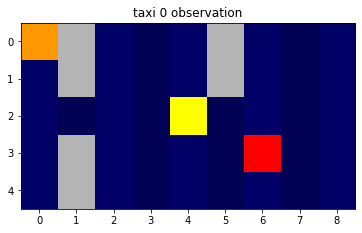

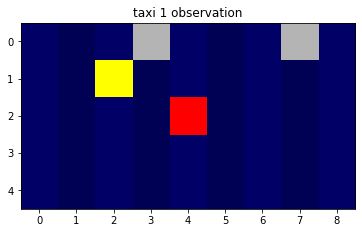

In [3]:
import matplotlib.pyplot as plt

# symbolic observations WITHOUT awareness of other taxis in the environment
env_instance_symbolic_obs_no_others = TaxiEnv(num_taxis=2, observation_type='symbolic', can_see_others=False)
print(f"Symbolic Vector Observation no others:\n{env_instance_symbolic_obs_no_others.reset()['taxi_1']}")
env_instance_symbolic_obs_no_others.render()

# symbolic observations WITH awareness of other taxis in the environment
env_instance_symbolic_obs_with_others = TaxiEnv(num_taxis=2, observation_type='symbolic', can_see_others=True)
print()
print(f"Symbolic Vector Observation with others:\n{env_instance_symbolic_obs_with_others.reset()['taxi_1']}")
env_instance_symbolic_obs_with_others.render()

# image observations
print()
print("Image Observation:")
env_instance_image_obs = TaxiEnv(num_taxis=2, observation_type='image')
obs = env_instance_image_obs.reset()
env_instance_image_obs.render()

plt.figure()
plt.title('taxi 0 observation')
plt.imshow(obs['taxi_0'])

plt.figure()
plt.title('taxi 1 observation')
plt.imshow(obs['taxi_1'])
plt.show()

__Note:__ In image observations, fuel and gas station will have distinct colors (pink and purple), and passengers current locations and destinations will have close colors by values.

__Also, note:__ In symbolic observations, we can choose wether taxis are aware of each other via the hyper parameter <code>can_see_others</code>.

### Changing the Reward Table

The default reward table is:
<code>
    dict(
    step=-1,  # default reward for each timestep.
    no_fuel=-1,  # for reaching "no fuel" state.
    bad_pickup=-1,  # for pickup an empty cell or tries to pickup passenger when reached its capacity.
    bad_dropoff=-1,  # for dropping off passenger in farther point than it was before.
    bad_refuel=-1,  # for trying to fuel outside the fuel station.
    pickup=-1,  # for picking up.
    standby_engine_off=-1,  # for standing by with an off engine.
    turn_engine_on=-1,  # for turning engine on.
    turn_engine_off=-1,  # for turning engine off.
    standby_engine_on=-1,  # for standing by with engine on.
    intermediate_dropoff=2,  # for getting passenger closer to its destination.
    final_dropoff=100,  # for dropping passenger in its destination.
    hit_wall=-1,  # for hitting a wall.
    collision=-1, # for performing a collision, this is given in the collision timestep.
    collided=-1,  # for being in a collided status, this is given in the timesteps after the collision.
)</code>

Note that it is intended to be very elaborate. In the default version, the taxis get <code>-1</code> for default actions and "time that goes by", and this apply for many scenarios, s.t bad_pickup, standby, step...

We can use this elaboration in our advantage for customizing this dictionary (or only the parts of it that we would like to change, and then initialize an environment with our reward table of interest.

#### In the next example we'll initialize an environment where we speciall penalize taxis for making <code>bad_pickup</code> tries, all other rewards are the same.

In [4]:
# set custom reward for "bad_pickup"
customized_reward = dict(bad_pickup=-50)
env_instance = TaxiEnv(rewards_table=customized_reward)
env_instance.reset()

# do pickup action immediately after reset
obs, rewards, dones, _ = env_instance.step({'taxi_0': 4})
env_instance.render()

# see custom reward
print(f'\nreward for bad pickup: {rewards["taxi_0"]}')

+-----------------------+
| : |F: | : | : | : |F: |
| : | : : : | : | : | : |
| : : : : : : : : : : :_|
| : : : : : | : : : : : |
| : : : : : | : : : : : |
| : : : : : : : : : : : |
| | :G| | | :G| | | : | |
+-----------------------+
Taxi0-YELLOW: Fuel: inf, Location: (2,11), Collided: False
Passenger1: Location: (0, 4), Destination: (6, 10)
Done: False, {'taxi_0': False, '__all__': False}
Passengers Status's: [2]

reward for bad pickup: -50


### Stochastic Transitions

Setting the `stochastic_action_function` parameter adds a chance to fail performing the desired action. A stochastic function is any function that takes an action name and returns a new action name. To define a stochastic action function with a discrete action distribution, we can use `taxi_utils.StochasticActionFunction`, which accepts a dictionary probability distribution as initialization input is a callable function that will sample the actions according to the distribution.

In the below example, we define a probability distribution for the taxi's acitons. for taxi 1, there is a 50% chance of moving horizontally when performing a vertical advance action. taxi 2 has a 50% chance of moving vertically when trying to move horizontally. All other actions are deterministic, including taxi 3's actions.

NOTE: we can also provide a single callable as `stochastic_aciton_function` which would affect all taxis.

In [5]:
from multi_taxi.taxi_utils import StochasticActionFunction

# define a conditional action distributions for each taxi
taxi0_action_dist = {
    'north': {'north': 0.5, 'east': 0.25, 'west': 0.25},
    'south': {'south': 0.5, 'east': 0.25, 'west': 0.25}
}
taxi1_action_dist = {
    'east': {'east': 0.5, 'north': 0.25, 'south': 0.25},
    'west': {'west': 0.5, 'north': 0.25, 'south': 0.25}
}

# create a different stochast
f0 = StochasticActionFunction(taxi0_action_dist)
f1 = StochasticActionFunction(taxi1_action_dist)

# create an environment with stochastic functions f1,f2 for taxis 1 and 2 respectively. 
stochastic_env = TaxiEnv(num_taxis=3, stochastic_action_function={'taxi_0': f0, 'taxi_1': f1})
stochastic_env.reset()
stochastic_env.render()

+-----------------------+
| : |F: | : | : | : |F: |
| : | : : : | : | : | : |
| : : : : : : : : : : : |
| : : : : : | : : : : : |
| : : : : : | : : : : : |
| : : : : : :_:_: : :_: |
| | :G| | | :G| | | : | |
+-----------------------+
Taxi0-YELLOW: Fuel: inf, Location: (5,10), Collided: False
Taxi1-RED: Fuel: inf, Location: (5,7), Collided: False
Taxi2-WHITE: Fuel: inf, Location: (5,6), Collided: False
Passenger1: Location: (0, 11), Destination: (0, 9)
Done: False, {'taxi_0': False, 'taxi_1': False, 'taxi_2': False, '__all__': False}
Passengers Status's: [2]


In [6]:
# choose an action for each taxi to best demonstrate the stochasticity.
joint_action = {
    'taxi_0': stochastic_env.action_index_dictionary['north'],
    'taxi_1': stochastic_env.action_index_dictionary['west'],
    'taxi_2': stochastic_env.action_index_dictionary['north'],
}

# perform 5 constant actions and see the result
for _ in range(5):
    _, _, _, info = stochastic_env.step(joint_action)
    stochastic_env.render()
    
    # the info will show us the chosen action and the actual action that was performed
    print('taxi_0 info:', info['taxi_0'])
    print('taxi_1 info:', info['taxi_1'])
    print('taxi_2 info:', info['taxi_2'])  # should always perform the chosen action

+-----------------------+
| : |F: | : | : | : |F: |
| : | : : : | : | : | : |
| : : : : : : : : : : : |
| : : : : : | : : : : : |
| : : : : : |_:_: : :_: |
| : : : : : : : : : : : |
| | :G| | | :G| | | : | |
+-----------------------+
Taxi0-YELLOW: Fuel: inf, Location: (4,10), Collided: False
Taxi1-RED: Fuel: inf, Location: (4,7), Collided: False
Taxi2-WHITE: Fuel: inf, Location: (4,6), Collided: False
Passenger1: Location: (0, 11), Destination: (0, 9)
Done: False, {'taxi_0': False, 'taxi_1': False, 'taxi_2': False, '__all__': False}
Passengers Status's: [2]
taxi_0 info: {'last_chosen_actions': ['north'], 'last_performed_transitions': ['north']}
taxi_1 info: {'last_chosen_actions': ['west'], 'last_performed_transitions': ['north']}
taxi_2 info: {'last_chosen_actions': ['north'], 'last_performed_transitions': ['north']}
+-----------------------+
| : |F: | : | : | : |F: |
| : | : : : | : | : | : |
| : : : : : : : : : : : |
| : : : : : |_: : : :_: |
| : : : : : | : : : : : |
| : : : : : : 

### For your convenience, we are also adding a simple example on training RLLib agents (PPO in this case) in our environment

In [7]:
# need torch for this cell, simply run:
# !pip install torch
import random

import ray
from ray import tune
from ray.rllib.examples.models.shared_weights_model import TorchSharedWeightsModel

from ray.rllib.models import ModelCatalog
from ray.rllib.policy.policy import PolicySpec
from ray.rllib.utils.test_utils import check_learning_achieved

ray.init(ignore_reinit_error=True, local_mode=True)

# Register the models to use.
mod1 = mod2 = TorchSharedWeightsModel
ModelCatalog.register_custom_model("model1", mod1)
ModelCatalog.register_custom_model("model2", mod2)

num_policies = 2
num_agents = 2

# Each policy can have a different configuration (including custom model).
def gen_policy(i):
    config = {
        "model": {
            "custom_model": ["model1", "model2"][i % 2],
        },
        "gamma": random.choice([0.95, 0.99]),
    }
    return PolicySpec(config=config)

# Setup PPO with an ensemble of `num_policies` different policies.
policies = {"taxi_{}".format(i): gen_policy(i) for i in range(num_policies)}
policy_ids = list(policies.keys())

def policy_mapping_fn(agent_id, episode, worker, **kwargs):
    return agent_id

config = {
    "env": TaxiEnv,
    "env_config": {
        "taxis_number": num_agents,
        "can_see_others": True
    },
    "num_gpus": 0,
    "horizon": 200,  # This is relevant because our env is episodic.
    "multiagent": {
        "policies": policies,
        "policy_mapping_fn": policy_mapping_fn,
    },
    "framework": "torch",
}
stop = {
#     "episode_reward_mean": 10,
    "timesteps_total": 1000,
}

results = tune.run("PPO", stop=stop, config=config, verbose=0)
# check_learning_achieved(results, 10)
ray.shutdown()

2022-03-21 18:30:01,800	WARNING worker.py:512 -- `ray.get_gpu_ids()` will always return the empty list when called from the driver. This is because Ray does not manage GPU allocations to the driver process.
:task_name:bundle_reservation_check_func
:actor_name:PPOTrainer
2022-03-21 18:30:01,881	INFO ppo.py:249 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
2022-03-21 18:30:01,882	INFO trainer.py:790 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
:actor_name:RolloutWorker
2022-03-21 18:30:01,965	WARNING deprecation.py:45 -- DeprecationWarning: `rllib.env.remote_vector_env.RemoteVectorEnv` has been deprecated. Use `ray.rllib.env.remote_base_env.RemoteBaseEnv` instead. This will raise an error in the future!
:actor_name:RolloutWorker
2022-03-21 18:30:02,011	WARNING util.py:55 -- Install gputil for GPU system mo

:task_name:bundle_reservation_check_func
:actor_name:PPOTrainer
:actor_name:RolloutWorker
:actor_name:RolloutWorker


2022-03-21 18:30:08,819	WARNING ppo.py:127 -- No data for taxi_1, not updating kl


### And just like that! We are good to go!

### After initializing the environemnt you can deploy to it any planner/ RL/ MARL algorithms that you like and works with gym.

# Enjoy!